In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

### Solving Linear Equations

In [1]:
# reference - # https://quantumcomputing.stackexchange.com/questions/20862/hhl-the-result-is-correct-for-one-matrix-but-wrong-for-another-one

https://www.youtube.com/watch?v=KtIPAPyaPOg

In [2]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.quantum_info import Statevector

from qiskit.algorithms.linear_solvers.hhl import HHL

import numpy as np
import math as m

# decimal to binary
def dec2bin(decimal, bits):
    b = bin(decimal)
    b = b[2:len(b)]
    while len(b) < bits:
        b = '0' + b
    return b

processor = Aer.backends(name='qasm_simulator')[0]
processor

QasmSimulator('qasm_simulator')

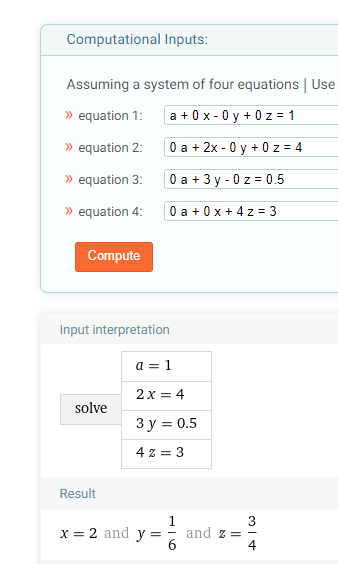

In [3]:
# 1st linear system; A*x = B
matrix_A = np.array([[1,0,0,0],[0,2,0,0],[0,0,3,0],[0,0,0,4]])
vector_b = np.array([1,4,0.5,3]) 

# solution = [1, 2, 0.1667, 0.75]

matrix_A

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 4]])

In [4]:
# number of variables (assuming n=2^k)
n = len(matrix_A[2,:])
n

4

In [5]:
# number of necessary qubits
n_qubits = m.ceil(m.log(n,2))
n_qubits

2

In [6]:
# norm of right-side
bNorm = np.linalg.norm(vector_b)
bNorm

5.123475382979799

In [7]:
hhlSolver = HHL(quantum_instance = processor)
hhlSolver

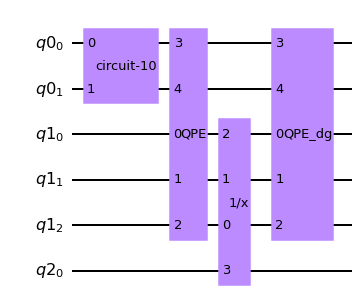

In [8]:
# preparing circuit in general form
hhlCircuit = hhlSolver.construct_circuit(matrix_A, vector_b)
hhlCircuit.draw()

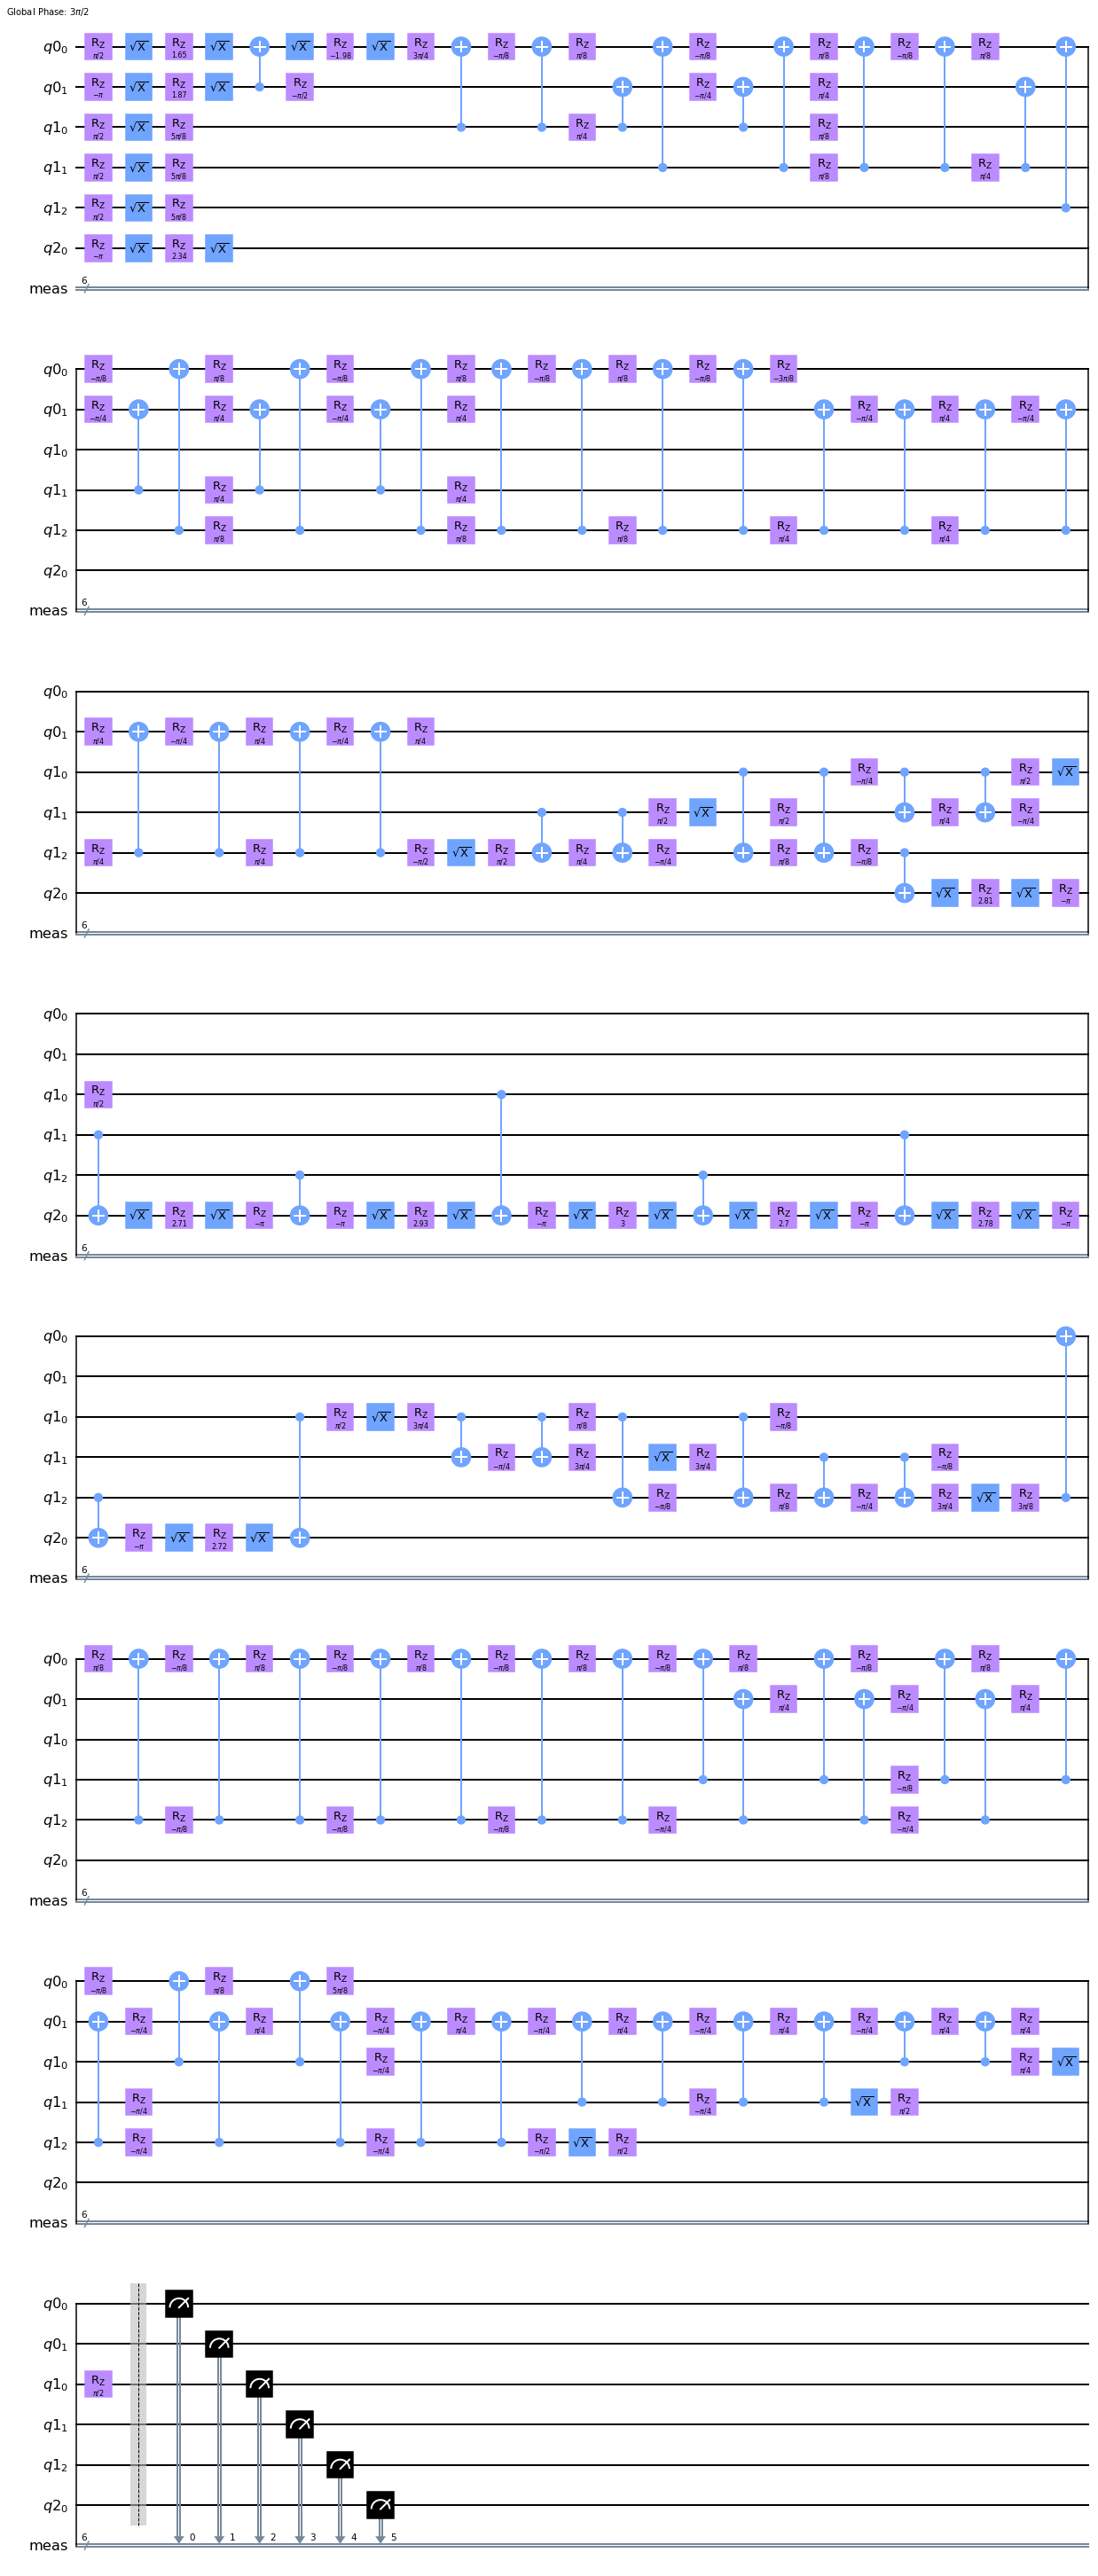

In [9]:
# transpile -- adapt circuit to real quantum processor
circuitToRun = transpile(hhlCircuit, basis_gates=['id', 'rz', 'sx', 'x', 'cx'])

# add measurement
circuitToRun.measure_all()

circuitToRun.draw()

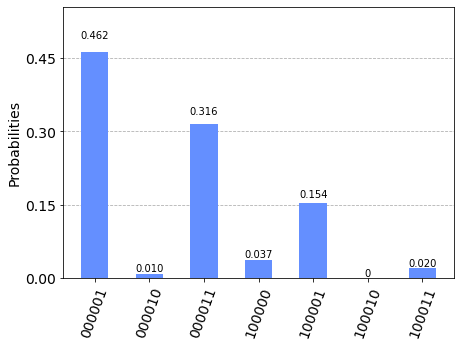

In [10]:
from qiskit.visualization import plot_histogram

# execute the circuit
shots = 8192
counts = execute(circuitToRun, processor, shots=shots).result().get_counts(circuitToRun)
plot_histogram(counts)

In [11]:
# width - num of qubits and classical bit summed
usedQubits = circuitToRun.width()/2
usedQubits

6.0

In [12]:
# working qubits
zeros = dec2bin(0, usedQubits - n_qubits - 1)

# ancilla qubit has to be |1>, working qubits |0>, results are in last "n_qubits" qubits
# e.g. if n_qubits and total qubits is 6, then 3 are working qubits
# results are stored in |1 000 00>, |1 000 01>, |1 000 10>, |1 000 11>
for i in range(0,n):
    indx = '1' + zeros + dec2bin(i, n_qubits)
    # bNorm*m.sqrt(M[indx]/shots) - we need probability amplitudes => sqrt
    # and adjust them by norm of vector b to get "unnormalized" solution x
    print('x_' + str(i) + ': ' + str(round(bNorm*m.sqrt(counts[indx]/shots),4)))

x_0: 0.9886
x_1: 2.0125
x_2: 0.1498
x_3: 0.7271
